## Pesquisa

Essa pesquisa tem o objetivo de analisar os dados de simulação do Tennessee Eastman com o algoritmo de seleção SHAP, em conjunto com o Random Forest para classificar as falhas, caso sejam ou não a falha informada. Aprofundando no tema, a ideia é utilizar o algortimo SHAP para verificar quais váriaveis conseguem identificar uma falha, por exemplo, unindo todas as falhas e separando uma delas para ser a classe verdadeira, podemos identificar quais variaveis tiveram maior contribuição para aquela especifica falha.

### Separação dos dados

Os dados foram separados em treino, teste e validação. Os dados de treino e de testes foram montados com as primeiras 40 ocorrencias de cada, exceto a selecionada para ser a classe positiva. Já os dados de validação, são os dados não utilizados pelas demais separações.

### Tecnologia implementada

Nesse artigo, foi utilizado o algoritmo SHAP para a seleção das variaveis mais importantes para identificar a falha e o Random Forest para classificar e testar tais variaveis.
Para a classificação, foi utilizado para medir o poder do conjunto utilizando as métrica F1, acuracia, recall, espeficidade e precisão.
Para fins de comparação, foram utilizados alguns gráficos e heatmaps para melhor analise entre artigos selecionados.

In [4]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pylab as plt
from tennessee_eastman import get_faulty_by_id, get_faulties
from shap_contribution import get_shap_contribution, plot_variable
from pca_contribution import get_pca_contribution, t2s, t2t
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_selection import RFE, f_classif, SelectFromModel, mutual_info_classif,SelectKBest
import warnings
import sys
from tabulate import tabulate

plt.style.use("seaborn")
warnings.filterwarnings("ignore")

In [5]:
def select_features(X, y, selector='RFE'):
    model = RandomForestClassifier(random_state=1234)

    if selector == 'RFE':
        selector = RFE(model, n_features_to_select=10)
        selector.fit(X, y)
    if selector == 'FromModel':
        selector = SelectFromModel(estimator=model, max_features=10)
        selector.fit(X, y)
    if selector == 'Classif':
        selector = SelectKBest(f_classif, k=10)
        selector.fit_transform(X_train, y_train)
    if selector == 'MultiClassif':
        selector = SelectKBest(mutual_info_classif, k=10)
        selector.fit_transform(X_train, y_train)


    return np.nonzero(selector.get_support())

### Creating the heat map data with all variables and failures (The heat map is shown in the end of this file)

In [6]:
all_contributions= []

for i in range(1, 22):
    # Setting up the dataset with all falties with binary distribution
    X_train, y_train, X_test, y_test = get_faulties(i)

    model = RandomForestClassifier(random_state=1234)

    # Calculating the variables contributions
    contributions = get_shap_contribution(model, X_train, y_train, X_test)

    aux = contributions.to_numpy()

    all_contributions.append(aux / aux.sum(axis=0) * 100)

heatmap_data  = all_contributions = np.array(all_contributions).reshape(21, 52)

### Calculating with all metrics and selecting the best variables for each failures

In [7]:
all_contributions = pd.DataFrame()
all_accuracies = pd.DataFrame()

for i in range(1, 22):
    # Setting up the dataset with all falties with binary distribution
    X_train, y_train, X_test, y_test = get_faulties(i)

    model = RandomForestClassifier(random_state=1234)

    # Calculating the variables contributions
    contributions = get_shap_contribution(model, X_train, y_train, X_test, True)

    accuracies = []
    f1s = []
    recalls = []
    precisions = []
    specificities = []

    all_scores = []
    scores = []
    used_variables = []
    all_variables = contribution_indexes = contributions.index.to_numpy()

    X_temporary = np.array([])
    X_test_temporary = np.array([])

    stop = False

    selectorsF1 = []

    for selectorName in ['RFE', 'FromModel', 'Classif', 'MultiClassif']:
        indexes = select_features(X_train, y_train, selectorName)

        X_selected = X_train[:, indexes[0]]
        X_test_selected = X_test[:, indexes[0]]

        model = RandomForestClassifier(random_state=1234)

        model.fit(X_selected, y_train)
        predicted = model.predict(X_test_selected)

        selectorsF1.append(f1_score(y_test, predicted))

    for j in range(X_train.shape[1]):
        model = RandomForestClassifier(random_state=1234)

        # Setting up a new dataset with the selected variables
        X_temporary = np.concatenate((X_temporary,  np.array([X_train[:, contribution_indexes[0]]]).T), axis=1) if X_temporary.shape[0] > 0 else np.array([X_train[:, contribution_indexes[0]]]).T
        X_test_temporary = np.concatenate((X_test_temporary,  np.array([X_test[:, contribution_indexes[0]]]).T), axis=1) if X_test_temporary.shape[0] > 0 else np.array([X_test[:, contribution_indexes[0]]]).T

        model.fit(X_temporary, y_train)
        predicted = model.predict(X_test_temporary)

        # Calculating all metrics
        f1_aux = f1_score(y_test, predicted)
        accuracy_aux = accuracy_score(y_test, predicted)
        recall_aux = recall_score(y_test, predicted)
        precision_aux = precision_score(y_test, predicted)
        tn_aux, fp_aux, fn_aux, tp_aux = confusion_matrix(y_test, predicted).ravel()
        specificity_aux = tn_aux/(tn_aux+fp_aux)

        if stop == False and (len(scores) == 0 or (len(scores) > 0 and scores[len(scores) - 1] <= f1_aux)):
            used_variables.append(contribution_indexes[0])
            scores.append(f1_aux)
            f1 = f1_aux
            accuracy = accuracy_aux
            recall = recall_aux
            precision = precision_aux
            tn = tn_aux
            fp = fp_aux
            fn = fn_aux
            tp = tp_aux
            specificity = specificity_aux

            contribution_indexes = np.delete(contribution_indexes,0)
        else:
            stop = True

        all_scores.append(f1_aux)

    # Adding this accuracy to the dataframe
    all_accuracies = all_accuracies.append({'index': i, 'f1': f1, 'accuracy': accuracy, 'recall': recall, 'precision': precision, 'specificity': specificity, 'tn':tn, 'fp': fp, 'fn': fn,'tp':tp, 'scores': scores, 'all_scores': all_scores, 'used_variables': used_variables, 'all_variables': all_variables, 'rfe': selectorsF1[0], 'fromModel': selectorsF1[1], 'class': selectorsF1[2],'multiclass': selectorsF1[3] }, ignore_index=True)

    # Adding this contribution to the dataframe
    all_contributions = all_contributions.append({'index': i, 'value': contributions.index}, ignore_index=True)

##### Simple metrics results

In [8]:
print(tabulate(all_accuracies.drop(['scores', 'all_scores', 'used_variables', 'all_variables', 'rfe', 'fromModel', 'class', 'multiclass'], axis=1).round(4), tablefmt='psql', headers="keys"))

+----+---------+--------+------------+----------+-------------+---------------+------+------+------+------+
|    |   index |     f1 |   accuracy |   recall |   precision |   specificity |   tn |   fp |   fn |   tp |
|----+---------+--------+------------+----------+-------------+---------------+------+------+------+------|
|  0 |       1 | 0.9918 |     0.9926 |   0.9838 |      1      |        1      |  960 |    0 |   13 |  787 |
|  1 |       2 | 0.9924 |     0.9932 |   0.985  |      1      |        1      |  960 |    0 |   12 |  788 |
|  2 |       3 | 0.624  |     0.7199 |   0.5112 |      0.8004 |        0.8938 |  858 |  102 |  391 |  409 |
|  3 |       4 | 0.9994 |     0.9994 |   0.9988 |      1      |        1      |  960 |    0 |    1 |  799 |
|  4 |       5 | 0.9893 |     0.9903 |   0.9812 |      0.9975 |        0.9979 |  958 |    2 |   15 |  785 |
|  5 |       6 | 1      |     1      |   1      |      1      |        1      |  960 |    0 |    0 |  800 |
|  6 |       7 | 1      |   

##### Selected variables and scores

In [9]:
temporary_df = all_accuracies.copy()

for i in range(len(temporary_df['scores'])):
    for j in range(len(temporary_df['scores'][i])):
        temporary_df['scores'][i][j] = round(temporary_df['scores'][i][j], 4)

print(tabulate(temporary_df[['index', 'scores', 'used_variables']], tablefmt='psql', headers='keys', maxcolwidths=[1, 1, 50, 50]))

+----+---------+----------------------------------------------------+----------------------------------------------------+
|    |   index | scores                                             | used_variables                                     |
|----+---------+----------------------------------------------------+----------------------------------------------------|
|  0 |       1 | [0.9825, 0.9912, 0.9912, 0.9912, 0.9912, 0.9912,   | [0, 43, 3, 49, 17, 18, 44, 33, 9, 37, 19, 22, 28,  |
|    |         | 0.9912, 0.9912, 0.9912, 0.9912, 0.9912, 0.9912,    | 27, 46, 24]                                        |
|    |         | 0.9912, 0.9912, 0.9912, 0.9918]                    |                                                    |
|  1 |       2 | [0.985, 0.9918, 0.9918, 0.9918, 0.9918, 0.9924,    | [9, 46, 33, 27, 18, 49, 21]                        |
|    |         | 0.9924]                                            |                                                    |
|  2 |       3 |

##### All variables and scores

In [10]:
for i in range(len(temporary_df['all_scores'])):
    for j in range(len(temporary_df['all_scores'][i])):
        temporary_df['all_scores'][i][j] = round(temporary_df['all_scores'][i][j], 4)

print(tabulate(all_accuracies[['index', 'all_scores', 'all_variables']], tablefmt='psql', headers='keys', maxcolwidths=[1, 1, 50, 50]))

+----+---------+----------------------------------------------------+----------------------------------------------------+
|    |   index | all_scores                                         | all_variables                                      |
|----+---------+----------------------------------------------------+----------------------------------------------------|
|  0 |       1 | [0.9825, 0.9912, 0.9912, 0.9912, 0.9912, 0.9912,   | [ 0 43  3 49 17 18 44 33  9 37 19 22 28 27 46 24   |
|    |         | 0.9912, 0.9912, 0.9912, 0.9912, 0.9912, 0.9912,    | 6 32  7 30 12 15 40 34  10 26 20 21 45 42 29 38 50 |
|    |         | 0.9912, 0.9912, 0.9912, 0.9918, 0.9912, 0.9912,    | 35 31  2 36 13  5 23 25 39 51  1 14 48 16 41   4   |
|    |         | 0.9912, 0.9918, 0.9912, 0.9912, 0.9912, 0.9924,    | 47  8 11]                                          |
|    |         | 0.9912, 0.9918, 0.9918, 0.9912, 0.9924, 0.9912,    |                                                    |
|    |         |

##### Score results with selected variables

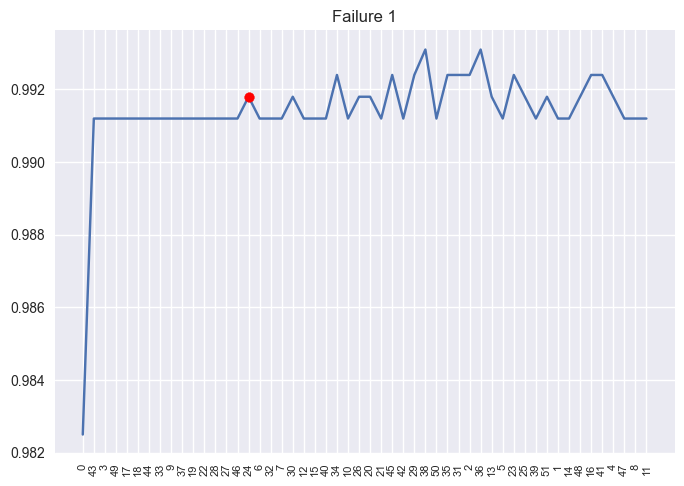

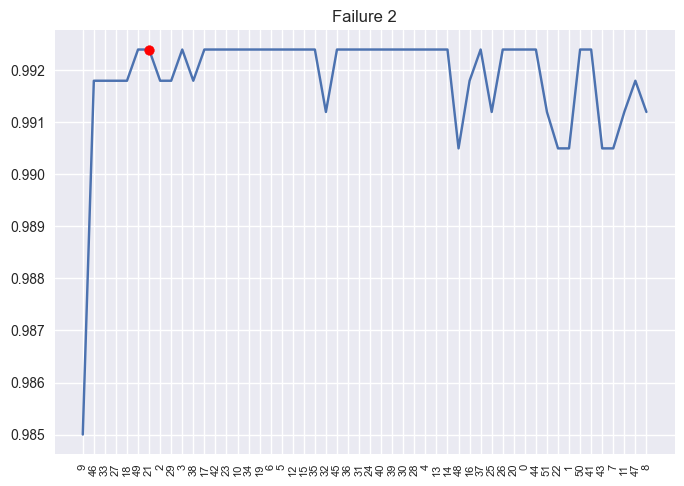

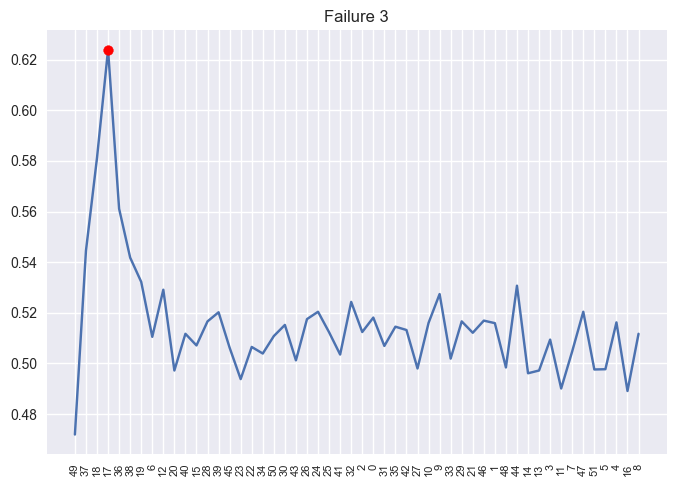

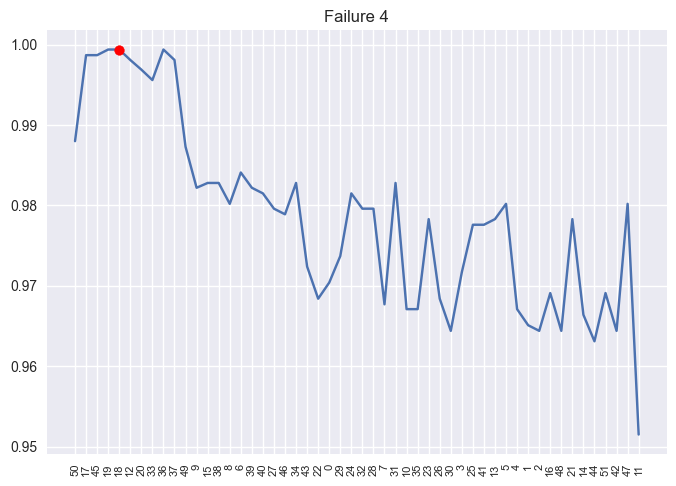

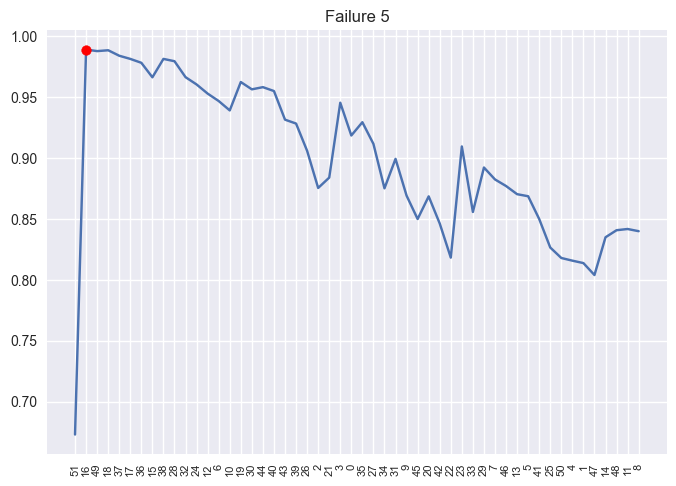

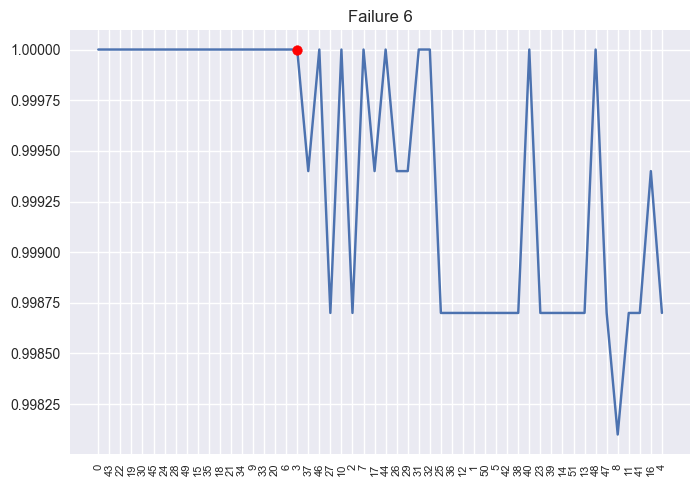

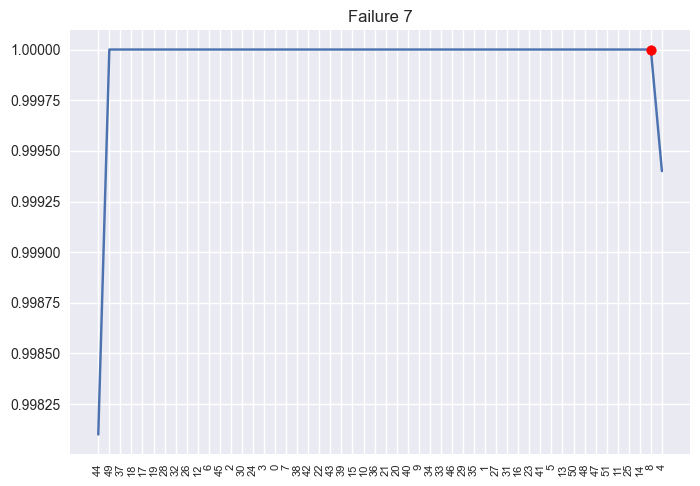

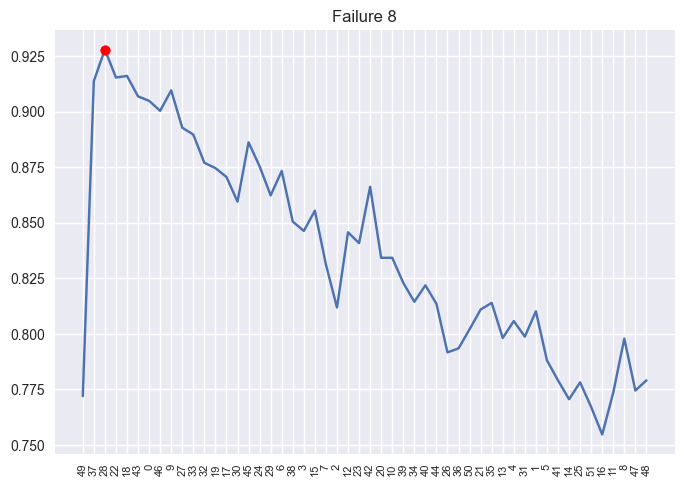

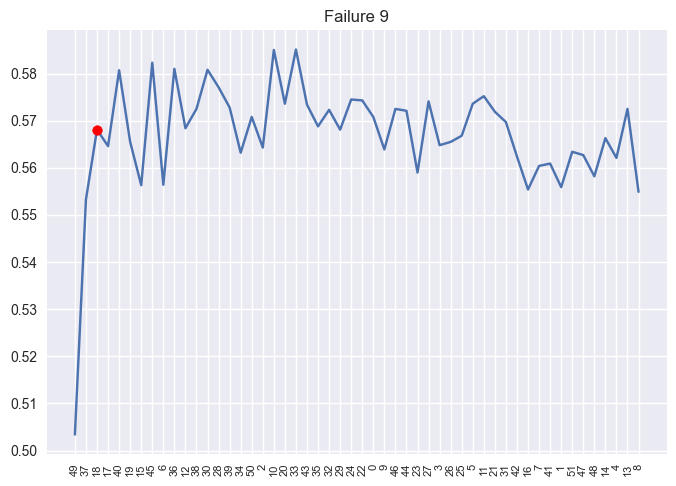

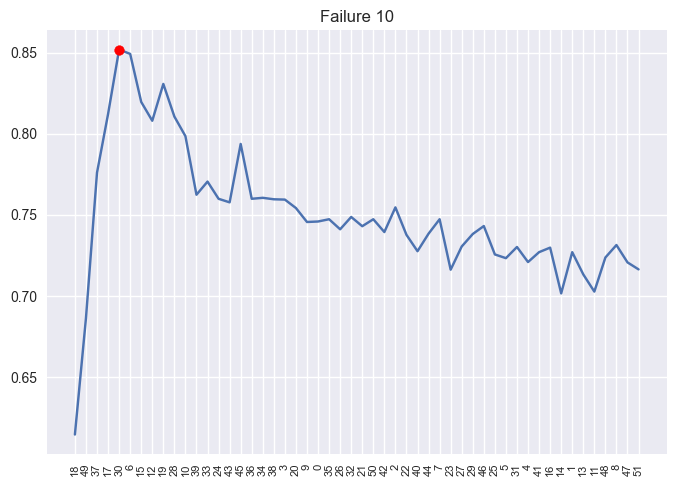

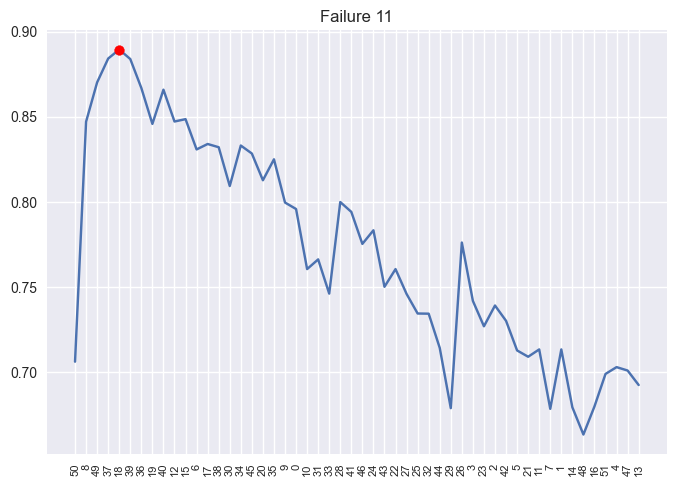

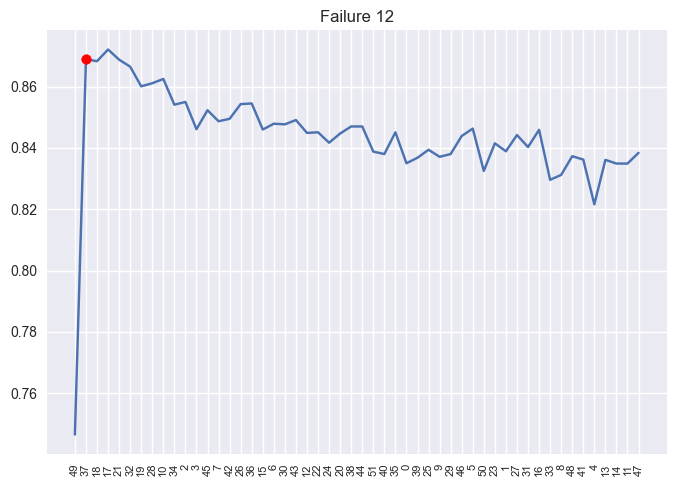

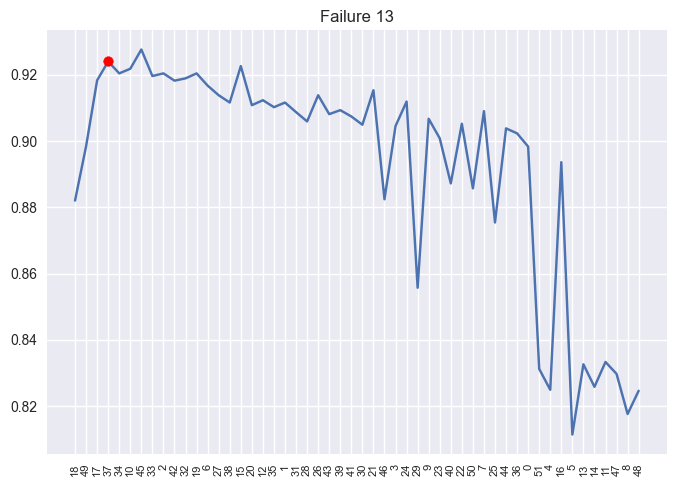

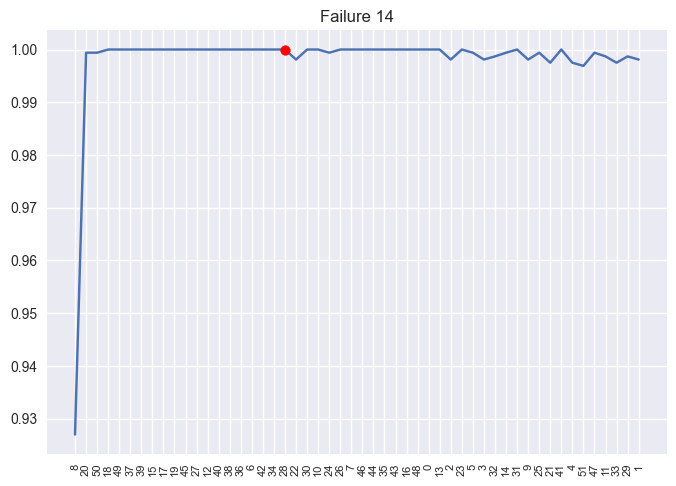

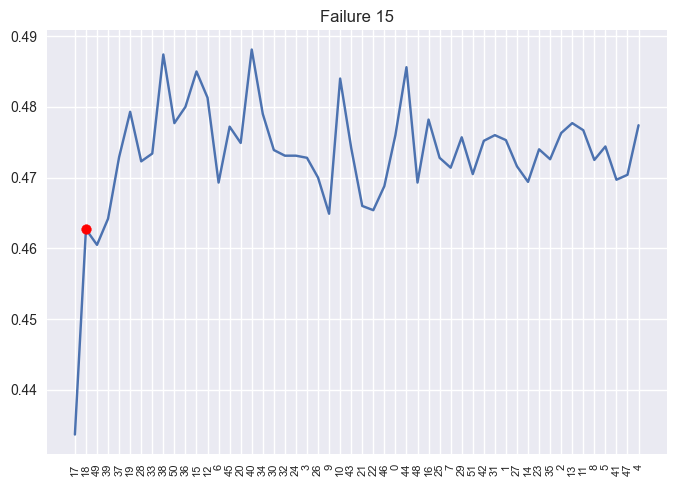

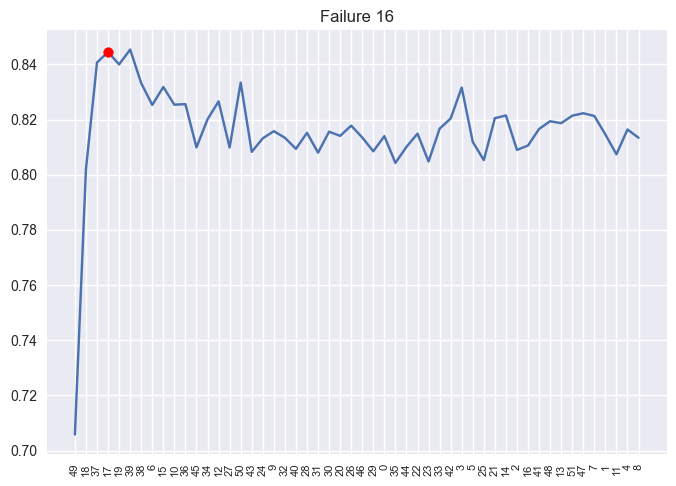

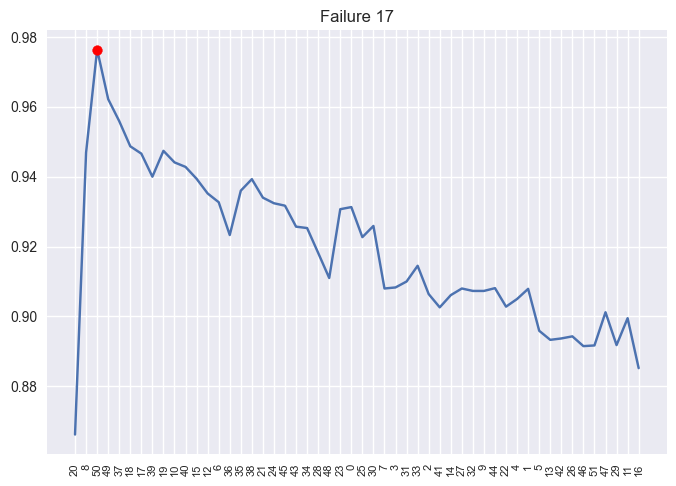

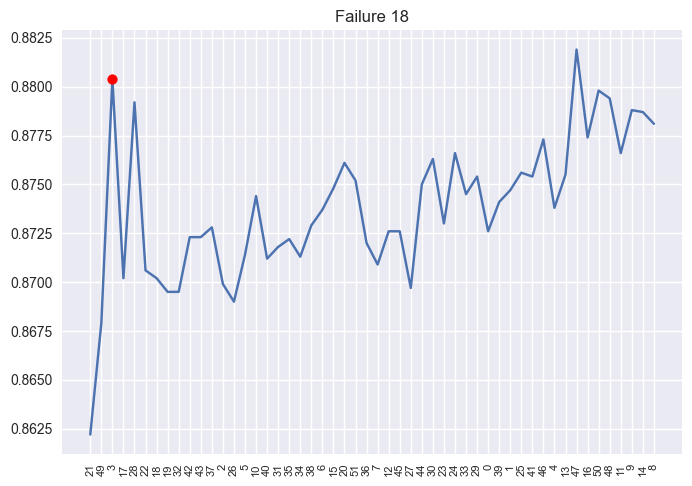

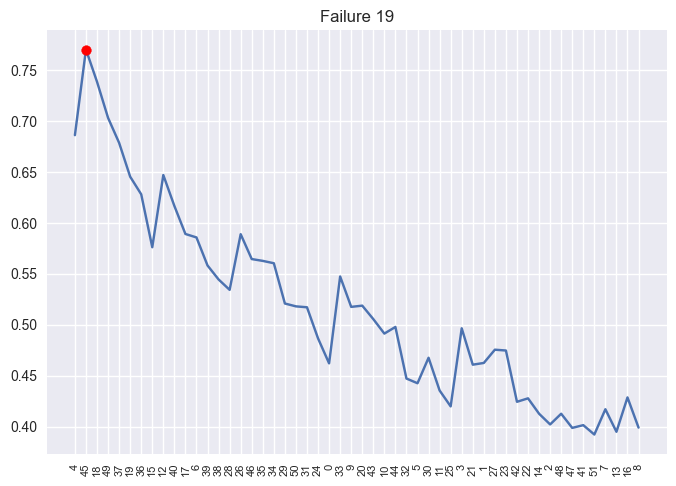

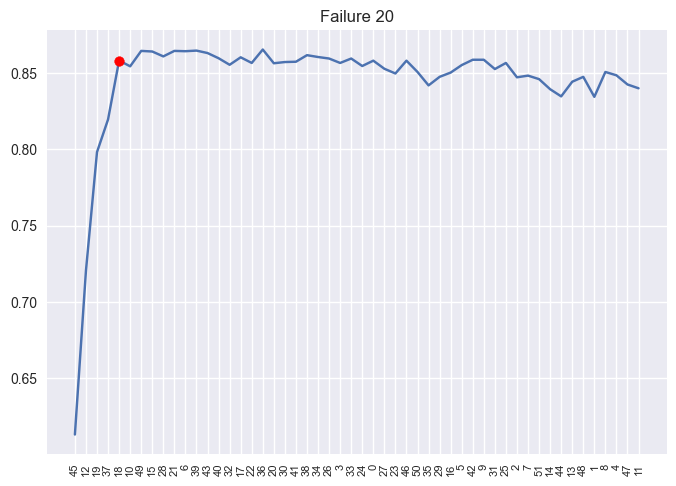

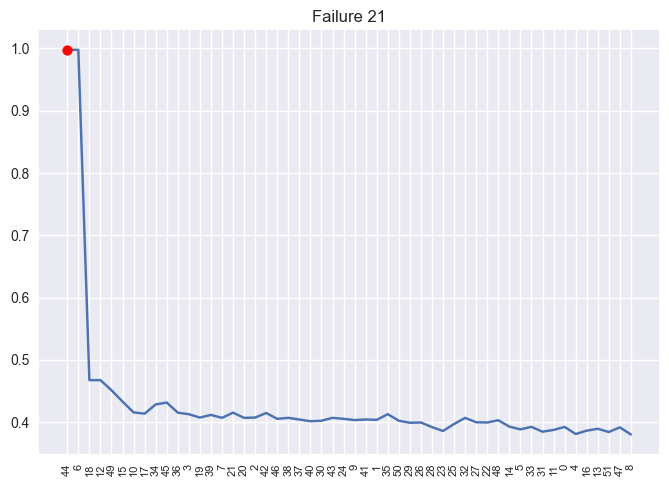

In [11]:
for failure in range(21):
    plt.plot(all_accuracies["all_scores"][failure], zorder=1)
    plt.xticks(range(52),all_accuracies["all_variables"][failure], fontsize=8, rotation=90)

    plt.scatter(x=len(all_accuracies["used_variables"][failure]) - 1, y=next(reversed(all_accuracies["scores"][failure])), color='r', zorder=2)
    plt.title("Failure " + str(failure + 1))
    plt.show()

##### Heatmaps

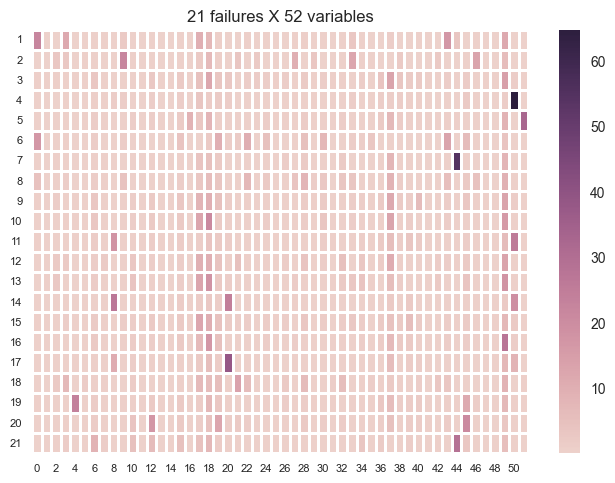

In [48]:
np.set_printoptions(threshold=sys.maxsize, suppress = True)
np.set_printoptions()

fig = plt.figure()
heat_map = sns.heatmap(heatmap_data, linewidth = 1, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('21 failures X 52 variables')
plt.yticks(np.arange(1, 22, 1) - 0.5, np.arange(1, 22, 1), fontsize=8, rotation=0, va='center')
plt.xticks(np.arange(0, 52, 2) + 0.5, np.arange(0, 52, 2), fontsize=8)
plt.show()
fig.savefig("2152.eps",format='eps')
plt.close()

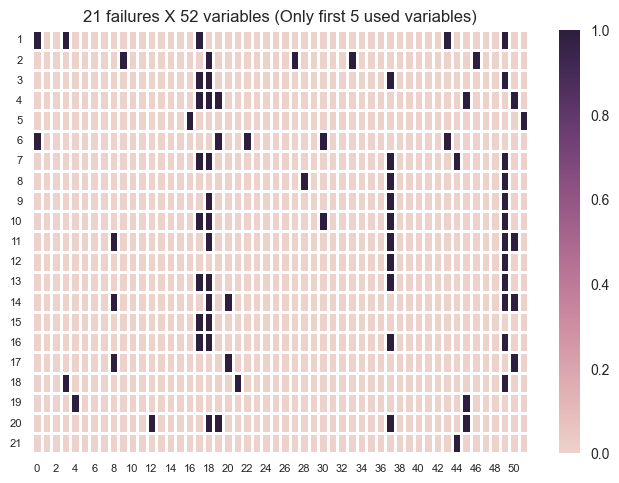

In [47]:
binary_heatmap_data = []

for i in range(21):
    binary_heatmap_data.append([])

    for j in range(52):
            binary_heatmap_data[i].append(0)


    added = 0

    for x in all_accuracies['used_variables'].to_numpy()[i]:
        if added < 5:
            binary_heatmap_data[i][x] = 1
            added += 1
        else:
            added = 0
            break

fig2 = plt.figure()
heat_map = sns.heatmap(binary_heatmap_data, linewidth = 1, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('21 failures X 52 variables (Only first 5 used variables)')
plt.yticks(np.arange(1, 22, 1) - 0.5, np.arange(1, 22, 1), fontsize=8, rotation=0, va='center')
plt.xticks(np.arange(0, 52, 2) + 0.5, np.arange(0, 52, 2), fontsize=8)
plt.show()
fig2.savefig("21525.eps",format='eps')
plt.close()

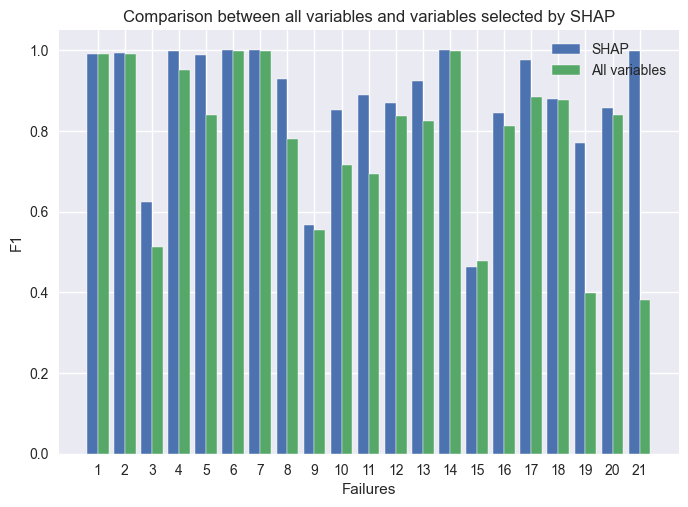

In [23]:
scores_bar = []
all_scores_bar = []

for i in range(21):
    scores_aux = all_accuracies['scores'].to_numpy()[i]
    all_scores_aux = all_accuracies['all_scores'].to_numpy()[i]

    scores_bar.append(scores_aux[len(scores_aux) - 1])
    all_scores_bar.append(all_scores_aux[len(all_scores_aux) - 1])

fig3 = plt.figure()
plt.bar(np.arange(21) - 0.2, scores_bar, 0.4, label = "SHAP")
plt.bar(np.arange(21) + 0.2, all_scores_bar, 0.4, label = "All variables")

plt.xticks(range(21), range(1, 22))
plt.xlabel("Failures")
plt.ylabel("F1")
plt.title("Comparison between all variables and variables selected by SHAP")
plt.legend()
plt.show()
fig3.savefig("Comparisonall.eps",format='eps')
plt.close()

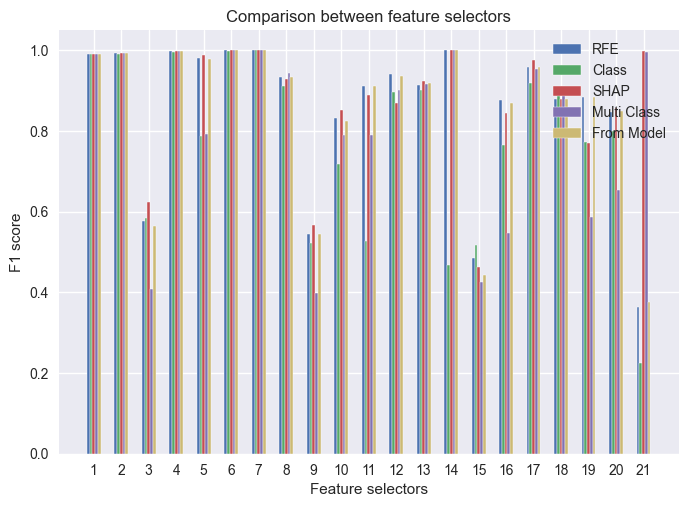

In [25]:
rfe_score = all_accuracies['rfe']
class_score = all_accuracies['class']
shap_score = all_accuracies['f1']
multi_score = all_accuracies['multiclass']
model_score = all_accuracies['fromModel']

fig4 = plt.figure()
plt.bar(np.arange(21) - 0.2, rfe_score, 0.1, label = "RFE")
plt.bar(np.arange(21) - 0.1 , class_score, 0.1, label = "Class")
plt.bar(np.arange(21), shap_score, 0.1, label = "SHAP")
plt.bar(np.arange(21) + 0.1, multi_score, 0.1, label = "Multi Class")
plt.bar(np.arange(21) + 0.2, model_score, 0.1, label = "From Model")

plt.xticks(range(21), range(1, 22))
plt.xlabel("Feature selectors")
plt.ylabel("F1 score")
plt.title("Comparison between feature selectors")
plt.legend()
fig4.savefig("Comparisonbetween.eps",format='eps')
plt.show()
plt.close()

In [52]:
print(tabulate(all_accuracies[['f1', 'rfe', 'fromModel', 'class', 'multiclass']].round(4), tablefmt='psql', headers="keys"))

+----+--------+--------+-------------+---------+--------------+
|    |     f1 |    rfe |   fromModel |   class |   multiclass |
|----+--------+--------+-------------+---------+--------------|
|  0 | 0.9918 | 0.9912 |      0.9912 |  0.9912 |       0.9912 |
|  1 | 0.9924 | 0.9924 |      0.9924 |  0.9918 |       0.9924 |
|  2 | 0.624  | 0.578  |      0.564  |  0.5848 |       0.4086 |
|  3 | 0.9994 | 0.9987 |      0.9987 |  0.9969 |       0.9981 |
|  4 | 0.9893 | 0.9802 |      0.9777 |  0.7869 |       0.793  |
|  5 | 1      | 1      |      1      |  0.9987 |       1      |
|  6 | 1      | 1      |      1      |  1      |       1      |
|  7 | 0.9281 | 0.9341 |      0.934  |  0.9116 |       0.9432 |
|  8 | 0.5681 | 0.544  |      0.5459 |  0.5215 |       0.3974 |
|  9 | 0.8519 | 0.8325 |      0.824  |  0.7193 |       0.7898 |
| 10 | 0.8896 | 0.912  |      0.9117 |  0.5276 |       0.7903 |
| 11 | 0.8689 | 0.9406 |      0.9371 |  0.8975 |       0.9019 |
| 12 | 0.924  | 0.9153 |      0.9182 |  

## Conclusão

Como demonstrado nessa implementação, o SHAP obteve um grande ganho comparado a utilização de todos os dados. Também foi demonstrado que a condição de parada para a escolha das variáveis pode ser removido, pois resultados melhores podem ser obtidos em troca de maior uso de dados.

Analizando os gráficos produzidos de cada variável escolhida pelo SHAP, nota-se que as variáveis mais importantes são as que tem maior variação nas amostras, aumentando a taxa de detecção dessas falhas. Além disso, em comparação com outros seletores de variáveis, o SHAP apresenta maior consistência na métrica F1 em todos as falhas. O RFE também teve ótimo desempenho, entretanto, na falha 21 não obteve um bom resultado.

Segundo o heatmap, é possível identificar as falhas de acordo com a oscilação de cada variável ao decorrer das amostras, já que para cada falha as primeiras 5 variáveis selecionadas são diferentes entre as demais. Também é possível remover certas variáveis do conjunto de dados, pois não são utilizados pelo SHAP e podem reduzir a acurácia do modelo.

